##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Train and serve a TensorFlow model with TensorFlow Serving

**Warning: This notebook is designed to be run in a Google Colab only**.  It installs packages on the system and requires root access.  If you want to run it in a local Jupyter notebook, please proceed with caution.

Note: You can run this example right now in a Jupyter-style notebook, no setup required!  Just click "Run in Google Colab"

<div class="devsite-table-wrapper"><table class="tfo-notebook-buttons" align="left">
<tr><td><a target="_blank" href="https://www.tensorflow.org/tfx/tutorials/serving/rest_simple">
<img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a></td>
<td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/tfx/blob/master/docs/tutorials/serving/rest_simple.ipynb">
<img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a></td>
<td><a target="_blank" href="https://github.com/tensorflow/tfx/blob/master/docs/tutorials/serving/rest_simple.ipynb">
<img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">View source on GitHub</a></td>
<td><a href="https://storage.googleapis.com/tensorflow_docs/tfx/docs/tutorials/serving/rest_simple.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td>
</tr></table></div>

This guide trains a neural network model to classify [images of clothing, like sneakers and shirts](https://github.com/zalandoresearch/fashion-mnist), saves the trained model, and then serves it with [TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving).  The focus is on TensorFlow Serving, rather than the modeling and training in TensorFlow, so for a complete example which focuses on the modeling and training see the [Basic Classification example](https://github.com/tensorflow/docs/blob/master/site/en/r1/tutorials/keras/basic_classification.ipynb).

This guide uses [tf.keras](https://github.com/tensorflow/docs/blob/master/site/en/r1/guide/keras.ipynb), a high-level API to build and train models in TensorFlow.

In [2]:
import sys

# Confirm that we're using Python 3
assert sys.version_info.major == 3, 'Oops, not running Python 3. Use Runtime > Change runtime type'

In [3]:
# TensorFlow and tf.keras
print("Installing dependencies for Colab environment")
!pip install -Uq grpcio==1.26.0

import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

print('TensorFlow version: {}'.format(tf.__version__))

Installing dependencies for Colab environment


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.55.1 requires grpcio!=1.48.0,<2,>=1.33.1, but you have grpcio 1.26.0 which is incompatible.
google-cloud-pubsub 2.21.1 requires grpcio<2.0dev,>=1.51.3, but you have grpcio 1.26.0 which is incompatible.
google-cloud-pubsublite 1.10.0 requires grpcio<2.0.0dev,>=1.38.1, but you have grpcio 1.26.0 which is incompatible.
grpc-google-iam-v1 0.13.0 requires grpcio<2.0.0dev,>=1.44.0, but you have grpcio 1.26.0 which is incompatible.
grpc-interceptor 0.15.4 requires grpcio<2.0.0,>=1.49.1, but you have grpcio 1.26.0 which is incompatible.
grpcio-status 1.48.2 requires grpcio>=1.48.2, but you have grpcio 1.26.0 which is incompatible.
tensorboard 2.15.2 requires grpcio>=1.48.2, but you have grpcio 1.26.0 which is incompatible.
tf-keras 2.16.0 requires tensorflow<2.17,>=2.16, but you have tensorflow 2.15.1 which 

2024-04-30 10:41:08.716822: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 10:41:08.716875: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 10:41:08.718684: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.15.1


## Create your model

### Import the Fashion MNIST dataset

This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. You can access the Fashion MNIST directly from TensorFlow, just import and load the data.

Note: Although these are really images, they are loaded as NumPy arrays and not binary image objects.

In [4]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# scale the values to 0.0 to 1.0
train_images = train_images / 255.0
test_images = test_images / 255.0

# reshape for feeding into the model
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('\ntrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))

 8192/29515 [=======>......................] - ETA: 0s

29515/29515 [==============================] - 0s 0us/step


    8192/26421880 [..............................] - ETA: 0s

 9617408/26421880 [=========>....................] - ETA: 0s

23470080/26421880 [=========================>....] - ETA: 0s

26421880/26421880 [==============================] - 0s 0us/step


5148/5148 [==============================] - 0s 0us/step


   8192/4422102 [..............................] - ETA: 0s

4422102/4422102 [==============================] - 0s 0us/step



train_images.shape: (60000, 28, 28, 1), of float64
test_images.shape: (10000, 28, 28, 1), of float64


### Train and evaluate your model

Let's use the simplest possible CNN, since we're not focused on the modeling part.

In [5]:
model = keras.Sequential([
  keras.layers.Conv2D(input_shape=(28,28,1), filters=8, kernel_size=3, 
                      strides=2, activation='relu', name='Conv1'),
  keras.layers.Flatten(),
  keras.layers.Dense(10, name='Dense')
])
model.summary()

testing = False
epochs = 5

model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(train_images, train_labels, epochs=epochs)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print('\nTest accuracy: {}'.format(test_acc))

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 Conv1 (Conv2D)              (None, 13, 13, 8)         80        


 flatten (Flatten)           (None, 1352)              0         


 Dense (Dense)               (None, 10)                13530     


Total params: 13610 (53.16 KB)


Trainable params: 13610 (53.16 KB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


Epoch 1/5


I0000 00:00:1714473676.987867  178558 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


   1/1875 [..............................] - ETA: 56:20 - loss: 2.2803 - sparse_categorical_accuracy: 0.1250

  21/1875 [..............................] - ETA: 4s - loss: 2.1357 - sparse_categorical_accuracy: 0.2887   

  43/1875 [..............................] - ETA: 4s - loss: 1.9041 - sparse_categorical_accuracy: 0.4092

  65/1875 [>.............................] - ETA: 4s - loss: 1.6405 - sparse_categorical_accuracy: 0.4899

  87/1875 [>.............................] - ETA: 4s - loss: 1.4544 - sparse_categorical_accuracy: 0.5435

 109/1875 [>.............................] - ETA: 4s - loss: 1.3202 - sparse_categorical_accuracy: 0.5843

 131/1875 [=>............................] - ETA: 4s - loss: 1.2308 - sparse_categorical_accuracy: 0.6093

 154/1875 [=>............................] - ETA: 4s - loss: 1.1491 - sparse_categorical_accuracy: 0.6301

 177/1875 [=>............................] - ETA: 3s - loss: 1.0887 - sparse_categorical_accuracy: 0.6487

 200/1875 [==>...........................] - ETA: 3s - loss: 1.0327 - sparse_categorical_accuracy: 0.6666

 222/1875 [==>...........................] - ETA: 3s - loss: 0.9906 - sparse_categorical_accuracy: 0.6789

 245/1875 [==>...........................] - ETA: 3s - loss: 0.9546 - sparse_categorical_accuracy: 0.6885

 267/1875 [===>..........................] - ETA: 3s - loss: 0.9196 - sparse_categorical_accuracy: 0.6991

 289/1875 [===>..........................] - ETA: 3s - loss: 0.8925 - sparse_categorical_accuracy: 0.7058

 311/1875 [===>..........................] - ETA: 3s - loss: 0.8701 - sparse_categorical_accuracy: 0.7125

 333/1875 [====>.........................] - ETA: 3s - loss: 0.8531 - sparse_categorical_accuracy: 0.7170

 356/1875 [====>.........................] - ETA: 3s - loss: 0.8350 - sparse_categorical_accuracy: 0.7227

 379/1875 [=====>........................] - ETA: 3s - loss: 0.8162 - sparse_categorical_accuracy: 0.7292

 402/1875 [=====>........................] - ETA: 3s - loss: 0.8013 - sparse_categorical_accuracy: 0.7327

 424/1875 [=====>........................] - ETA: 3s - loss: 0.7872 - sparse_categorical_accuracy: 0.7367

 446/1875 [======>.......................] - ETA: 3s - loss: 0.7752 - sparse_categorical_accuracy: 0.7405

 467/1875 [======>.......................] - ETA: 3s - loss: 0.7666 - sparse_categorical_accuracy: 0.7437

 489/1875 [======>.......................] - ETA: 3s - loss: 0.7550 - sparse_categorical_accuracy: 0.7473

 512/1875 [=======>......................] - ETA: 3s - loss: 0.7421 - sparse_categorical_accuracy: 0.7511

 534/1875 [=======>......................] - ETA: 3s - loss: 0.7350 - sparse_categorical_accuracy: 0.7535

 557/1875 [=======>......................] - ETA: 3s - loss: 0.7274 - sparse_categorical_accuracy: 0.7556

 580/1875 [========>.....................] - ETA: 2s - loss: 0.7190 - sparse_categorical_accuracy: 0.7586

 602/1875 [========>.....................] - ETA: 2s - loss: 0.7122 - sparse_categorical_accuracy: 0.7609

 624/1875 [========>.....................] - ETA: 2s - loss: 0.7058 - sparse_categorical_accuracy: 0.7627

 647/1875 [=========>....................] - ETA: 2s - loss: 0.6995 - sparse_categorical_accuracy: 0.7650

 670/1875 [=========>....................] - ETA: 2s - loss: 0.6917 - sparse_categorical_accuracy: 0.7674

 693/1875 [==========>...................] - ETA: 2s - loss: 0.6876 - sparse_categorical_accuracy: 0.7688

 716/1875 [==========>...................] - ETA: 2s - loss: 0.6828 - sparse_categorical_accuracy: 0.7701

 739/1875 [==========>...................] - ETA: 2s - loss: 0.6787 - sparse_categorical_accuracy: 0.7706

 762/1875 [===========>..................] - ETA: 2s - loss: 0.6739 - sparse_categorical_accuracy: 0.7724

 785/1875 [===========>..................] - ETA: 2s - loss: 0.6697 - sparse_categorical_accuracy: 0.7731

 808/1875 [===========>..................] - ETA: 2s - loss: 0.6664 - sparse_categorical_accuracy: 0.7741

 830/1875 [============>.................] - ETA: 2s - loss: 0.6621 - sparse_categorical_accuracy: 0.7753

 852/1875 [============>.................] - ETA: 2s - loss: 0.6580 - sparse_categorical_accuracy: 0.7765

 875/1875 [=============>................] - ETA: 2s - loss: 0.6558 - sparse_categorical_accuracy: 0.7767

 897/1875 [=============>................] - ETA: 2s - loss: 0.6519 - sparse_categorical_accuracy: 0.7779

 919/1875 [=============>................] - ETA: 2s - loss: 0.6494 - sparse_categorical_accuracy: 0.7786

 941/1875 [==============>...............] - ETA: 2s - loss: 0.6462 - sparse_categorical_accuracy: 0.7796

 963/1875 [==============>...............] - ETA: 2s - loss: 0.6424 - sparse_categorical_accuracy: 0.7806

 986/1875 [==============>...............] - ETA: 2s - loss: 0.6384 - sparse_categorical_accuracy: 0.7820

1008/1875 [===============>..............] - ETA: 1s - loss: 0.6364 - sparse_categorical_accuracy: 0.7826

1031/1875 [===============>..............] - ETA: 1s - loss: 0.6324 - sparse_categorical_accuracy: 0.7838

1054/1875 [===============>..............] - ETA: 1s - loss: 0.6299 - sparse_categorical_accuracy: 0.7840

1077/1875 [================>.............] - ETA: 1s - loss: 0.6266 - sparse_categorical_accuracy: 0.7850

1099/1875 [================>.............] - ETA: 1s - loss: 0.6233 - sparse_categorical_accuracy: 0.7860

1122/1875 [================>.............] - ETA: 1s - loss: 0.6203 - sparse_categorical_accuracy: 0.7866

1144/1875 [=================>............] - ETA: 1s - loss: 0.6178 - sparse_categorical_accuracy: 0.7873

1166/1875 [=================>............] - ETA: 1s - loss: 0.6155 - sparse_categorical_accuracy: 0.7877

1189/1875 [==================>...........] - ETA: 1s - loss: 0.6128 - sparse_categorical_accuracy: 0.7887

1211/1875 [==================>...........] - ETA: 1s - loss: 0.6110 - sparse_categorical_accuracy: 0.7892

1234/1875 [==================>...........] - ETA: 1s - loss: 0.6089 - sparse_categorical_accuracy: 0.7899

1257/1875 [===================>..........] - ETA: 1s - loss: 0.6074 - sparse_categorical_accuracy: 0.7902

1279/1875 [===================>..........] - ETA: 1s - loss: 0.6059 - sparse_categorical_accuracy: 0.7904

1302/1875 [===================>..........] - ETA: 1s - loss: 0.6043 - sparse_categorical_accuracy: 0.7909

1325/1875 [====================>.........] - ETA: 1s - loss: 0.6016 - sparse_categorical_accuracy: 0.7917

1347/1875 [====================>.........] - ETA: 1s - loss: 0.5994 - sparse_categorical_accuracy: 0.7925

1370/1875 [====================>.........] - ETA: 1s - loss: 0.5964 - sparse_categorical_accuracy: 0.7936

1393/1875 [=====================>........] - ETA: 1s - loss: 0.5947 - sparse_categorical_accuracy: 0.7940

1416/1875 [=====================>........] - ETA: 1s - loss: 0.5929 - sparse_categorical_accuracy: 0.7944

1439/1875 [======================>.......] - ETA: 0s - loss: 0.5911 - sparse_categorical_accuracy: 0.7952

1463/1875 [======================>.......] - ETA: 0s - loss: 0.5895 - sparse_categorical_accuracy: 0.7959

1486/1875 [======================>.......] - ETA: 0s - loss: 0.5878 - sparse_categorical_accuracy: 0.7966

1508/1875 [=======================>......] - ETA: 0s - loss: 0.5863 - sparse_categorical_accuracy: 0.7971

1532/1875 [=======================>......] - ETA: 0s - loss: 0.5851 - sparse_categorical_accuracy: 0.7978

1555/1875 [=======================>......] - ETA: 0s - loss: 0.5824 - sparse_categorical_accuracy: 0.7985

1578/1875 [========================>.....] - ETA: 0s - loss: 0.5807 - sparse_categorical_accuracy: 0.7991

1601/1875 [========================>.....] - ETA: 0s - loss: 0.5793 - sparse_categorical_accuracy: 0.7995

1623/1875 [========================>.....] - ETA: 0s - loss: 0.5782 - sparse_categorical_accuracy: 0.8000

1639/1875 [=========================>....] - ETA: 0s - loss: 0.5769 - sparse_categorical_accuracy: 0.8003

1660/1875 [=========================>....] - ETA: 0s - loss: 0.5760 - sparse_categorical_accuracy: 0.8006

1682/1875 [=========================>....] - ETA: 0s - loss: 0.5752 - sparse_categorical_accuracy: 0.8012

1704/1875 [==========================>...] - ETA: 0s - loss: 0.5737 - sparse_categorical_accuracy: 0.8017

1726/1875 [==========================>...] - ETA: 0s - loss: 0.5720 - sparse_categorical_accuracy: 0.8023

1748/1875 [==========================>...] - ETA: 0s - loss: 0.5708 - sparse_categorical_accuracy: 0.8026

1770/1875 [===========================>..] - ETA: 0s - loss: 0.5698 - sparse_categorical_accuracy: 0.8030

1792/1875 [===========================>..] - ETA: 0s - loss: 0.5675 - sparse_categorical_accuracy: 0.8038

1815/1875 [============================>.] - ETA: 0s - loss: 0.5660 - sparse_categorical_accuracy: 0.8043

1837/1875 [============================>.] - ETA: 0s - loss: 0.5640 - sparse_categorical_accuracy: 0.8049

1860/1875 [============================>.] - ETA: 0s - loss: 0.5628 - sparse_categorical_accuracy: 0.8054

1875/1875 [==============================] - 6s 2ms/step - loss: 0.5614 - sparse_categorical_accuracy: 0.8059


Epoch 2/5


   1/1875 [..............................] - ETA: 5s - loss: 0.2394 - sparse_categorical_accuracy: 0.9062

  24/1875 [..............................] - ETA: 4s - loss: 0.4493 - sparse_categorical_accuracy: 0.8568

  47/1875 [..............................] - ETA: 4s - loss: 0.4637 - sparse_categorical_accuracy: 0.8497

  70/1875 [>.............................] - ETA: 4s - loss: 0.4571 - sparse_categorical_accuracy: 0.8451

  93/1875 [>.............................] - ETA: 3s - loss: 0.4510 - sparse_categorical_accuracy: 0.8501

 116/1875 [>.............................] - ETA: 3s - loss: 0.4540 - sparse_categorical_accuracy: 0.8478

 139/1875 [=>............................] - ETA: 3s - loss: 0.4520 - sparse_categorical_accuracy: 0.8469

 161/1875 [=>............................] - ETA: 3s - loss: 0.4499 - sparse_categorical_accuracy: 0.8455

 183/1875 [=>............................] - ETA: 3s - loss: 0.4474 - sparse_categorical_accuracy: 0.8456

 205/1875 [==>...........................] - ETA: 3s - loss: 0.4470 - sparse_categorical_accuracy: 0.8451

 227/1875 [==>...........................] - ETA: 3s - loss: 0.4465 - sparse_categorical_accuracy: 0.8454

 249/1875 [==>...........................] - ETA: 3s - loss: 0.4475 - sparse_categorical_accuracy: 0.8427

 271/1875 [===>..........................] - ETA: 3s - loss: 0.4454 - sparse_categorical_accuracy: 0.8446

 293/1875 [===>..........................] - ETA: 3s - loss: 0.4463 - sparse_categorical_accuracy: 0.8435

 316/1875 [====>.........................] - ETA: 3s - loss: 0.4446 - sparse_categorical_accuracy: 0.8439

 339/1875 [====>.........................] - ETA: 3s - loss: 0.4420 - sparse_categorical_accuracy: 0.8463

 362/1875 [====>.........................] - ETA: 3s - loss: 0.4392 - sparse_categorical_accuracy: 0.8469

 384/1875 [=====>........................] - ETA: 3s - loss: 0.4415 - sparse_categorical_accuracy: 0.8463

 406/1875 [=====>........................] - ETA: 3s - loss: 0.4454 - sparse_categorical_accuracy: 0.8451

 429/1875 [=====>........................] - ETA: 3s - loss: 0.4467 - sparse_categorical_accuracy: 0.8445

 452/1875 [======>.......................] - ETA: 3s - loss: 0.4472 - sparse_categorical_accuracy: 0.8446

 475/1875 [======>.......................] - ETA: 3s - loss: 0.4453 - sparse_categorical_accuracy: 0.8445

 497/1875 [======>.......................] - ETA: 3s - loss: 0.4439 - sparse_categorical_accuracy: 0.8452

 519/1875 [=======>......................] - ETA: 3s - loss: 0.4410 - sparse_categorical_accuracy: 0.8460

 541/1875 [=======>......................] - ETA: 3s - loss: 0.4406 - sparse_categorical_accuracy: 0.8463

 563/1875 [========>.....................] - ETA: 2s - loss: 0.4412 - sparse_categorical_accuracy: 0.8463

 585/1875 [========>.....................] - ETA: 2s - loss: 0.4428 - sparse_categorical_accuracy: 0.8462

 606/1875 [========>.....................] - ETA: 2s - loss: 0.4437 - sparse_categorical_accuracy: 0.8460

 628/1875 [=========>....................] - ETA: 2s - loss: 0.4437 - sparse_categorical_accuracy: 0.8460

 649/1875 [=========>....................] - ETA: 2s - loss: 0.4437 - sparse_categorical_accuracy: 0.8454

 670/1875 [=========>....................] - ETA: 2s - loss: 0.4433 - sparse_categorical_accuracy: 0.8453

 692/1875 [==========>...................] - ETA: 2s - loss: 0.4444 - sparse_categorical_accuracy: 0.8449

 714/1875 [==========>...................] - ETA: 2s - loss: 0.4432 - sparse_categorical_accuracy: 0.8450

 736/1875 [==========>...................] - ETA: 2s - loss: 0.4427 - sparse_categorical_accuracy: 0.8452

 758/1875 [===========>..................] - ETA: 2s - loss: 0.4416 - sparse_categorical_accuracy: 0.8454

 781/1875 [===========>..................] - ETA: 2s - loss: 0.4399 - sparse_categorical_accuracy: 0.8462

 804/1875 [===========>..................] - ETA: 2s - loss: 0.4394 - sparse_categorical_accuracy: 0.8466

 827/1875 [============>.................] - ETA: 2s - loss: 0.4386 - sparse_categorical_accuracy: 0.8470

 849/1875 [============>.................] - ETA: 2s - loss: 0.4374 - sparse_categorical_accuracy: 0.8476

 871/1875 [============>.................] - ETA: 2s - loss: 0.4364 - sparse_categorical_accuracy: 0.8481

 893/1875 [=============>................] - ETA: 2s - loss: 0.4370 - sparse_categorical_accuracy: 0.8483

 916/1875 [=============>................] - ETA: 2s - loss: 0.4369 - sparse_categorical_accuracy: 0.8482

 938/1875 [==============>...............] - ETA: 2s - loss: 0.4358 - sparse_categorical_accuracy: 0.8486

 960/1875 [==============>...............] - ETA: 2s - loss: 0.4356 - sparse_categorical_accuracy: 0.8486

 982/1875 [==============>...............] - ETA: 2s - loss: 0.4362 - sparse_categorical_accuracy: 0.8484

1005/1875 [===============>..............] - ETA: 1s - loss: 0.4360 - sparse_categorical_accuracy: 0.8483

1028/1875 [===============>..............] - ETA: 1s - loss: 0.4359 - sparse_categorical_accuracy: 0.8479

1050/1875 [===============>..............] - ETA: 1s - loss: 0.4362 - sparse_categorical_accuracy: 0.8477

1073/1875 [================>.............] - ETA: 1s - loss: 0.4372 - sparse_categorical_accuracy: 0.8474

1095/1875 [================>.............] - ETA: 1s - loss: 0.4360 - sparse_categorical_accuracy: 0.8476

1117/1875 [================>.............] - ETA: 1s - loss: 0.4358 - sparse_categorical_accuracy: 0.8476

1139/1875 [=================>............] - ETA: 1s - loss: 0.4355 - sparse_categorical_accuracy: 0.8476

1161/1875 [=================>............] - ETA: 1s - loss: 0.4355 - sparse_categorical_accuracy: 0.8475

1183/1875 [=================>............] - ETA: 1s - loss: 0.4356 - sparse_categorical_accuracy: 0.8475

1205/1875 [==================>...........] - ETA: 1s - loss: 0.4349 - sparse_categorical_accuracy: 0.8480

1227/1875 [==================>...........] - ETA: 1s - loss: 0.4349 - sparse_categorical_accuracy: 0.8482

1249/1875 [==================>...........] - ETA: 1s - loss: 0.4341 - sparse_categorical_accuracy: 0.8484

1271/1875 [===================>..........] - ETA: 1s - loss: 0.4333 - sparse_categorical_accuracy: 0.8490

1293/1875 [===================>..........] - ETA: 1s - loss: 0.4342 - sparse_categorical_accuracy: 0.8487

1315/1875 [====================>.........] - ETA: 1s - loss: 0.4344 - sparse_categorical_accuracy: 0.8485

1337/1875 [====================>.........] - ETA: 1s - loss: 0.4348 - sparse_categorical_accuracy: 0.8481

1359/1875 [====================>.........] - ETA: 1s - loss: 0.4347 - sparse_categorical_accuracy: 0.8483

1381/1875 [=====================>........] - ETA: 1s - loss: 0.4355 - sparse_categorical_accuracy: 0.8477

1403/1875 [=====================>........] - ETA: 1s - loss: 0.4346 - sparse_categorical_accuracy: 0.8478

1425/1875 [=====================>........] - ETA: 1s - loss: 0.4346 - sparse_categorical_accuracy: 0.8479

1447/1875 [======================>.......] - ETA: 0s - loss: 0.4342 - sparse_categorical_accuracy: 0.8481

1469/1875 [======================>.......] - ETA: 0s - loss: 0.4342 - sparse_categorical_accuracy: 0.8482

1492/1875 [======================>.......] - ETA: 0s - loss: 0.4335 - sparse_categorical_accuracy: 0.8483

1514/1875 [=======================>......] - ETA: 0s - loss: 0.4338 - sparse_categorical_accuracy: 0.8482

1536/1875 [=======================>......] - ETA: 0s - loss: 0.4334 - sparse_categorical_accuracy: 0.8480

1558/1875 [=======================>......] - ETA: 0s - loss: 0.4337 - sparse_categorical_accuracy: 0.8480

1580/1875 [========================>.....] - ETA: 0s - loss: 0.4333 - sparse_categorical_accuracy: 0.8482

1603/1875 [========================>.....] - ETA: 0s - loss: 0.4335 - sparse_categorical_accuracy: 0.8483

1625/1875 [=========================>....] - ETA: 0s - loss: 0.4331 - sparse_categorical_accuracy: 0.8483

1647/1875 [=========================>....] - ETA: 0s - loss: 0.4327 - sparse_categorical_accuracy: 0.8482

1669/1875 [=========================>....] - ETA: 0s - loss: 0.4318 - sparse_categorical_accuracy: 0.8487

1692/1875 [==========================>...] - ETA: 0s - loss: 0.4314 - sparse_categorical_accuracy: 0.8487

1715/1875 [==========================>...] - ETA: 0s - loss: 0.4315 - sparse_categorical_accuracy: 0.8485

1738/1875 [==========================>...] - ETA: 0s - loss: 0.4305 - sparse_categorical_accuracy: 0.8489

1761/1875 [===========================>..] - ETA: 0s - loss: 0.4301 - sparse_categorical_accuracy: 0.8491

1783/1875 [===========================>..] - ETA: 0s - loss: 0.4298 - sparse_categorical_accuracy: 0.8492

1805/1875 [===========================>..] - ETA: 0s - loss: 0.4291 - sparse_categorical_accuracy: 0.8495

1826/1875 [============================>.] - ETA: 0s - loss: 0.4288 - sparse_categorical_accuracy: 0.8496

1848/1875 [============================>.] - ETA: 0s - loss: 0.4282 - sparse_categorical_accuracy: 0.8496

1870/1875 [============================>.] - ETA: 0s - loss: 0.4274 - sparse_categorical_accuracy: 0.8499

1875/1875 [==============================] - 4s 2ms/step - loss: 0.4274 - sparse_categorical_accuracy: 0.8499


Epoch 3/5


   1/1875 [..............................] - ETA: 5s - loss: 0.3440 - sparse_categorical_accuracy: 0.8438

  23/1875 [..............................] - ETA: 4s - loss: 0.4562 - sparse_categorical_accuracy: 0.8193

  45/1875 [..............................] - ETA: 4s - loss: 0.4491 - sparse_categorical_accuracy: 0.8333

  67/1875 [>.............................] - ETA: 4s - loss: 0.4324 - sparse_categorical_accuracy: 0.8400

  89/1875 [>.............................] - ETA: 4s - loss: 0.4163 - sparse_categorical_accuracy: 0.8438

 112/1875 [>.............................] - ETA: 4s - loss: 0.4166 - sparse_categorical_accuracy: 0.8446

 134/1875 [=>............................] - ETA: 3s - loss: 0.4089 - sparse_categorical_accuracy: 0.8507

 156/1875 [=>............................] - ETA: 3s - loss: 0.4090 - sparse_categorical_accuracy: 0.8532

 178/1875 [=>............................] - ETA: 3s - loss: 0.4056 - sparse_categorical_accuracy: 0.8553

 200/1875 [==>...........................] - ETA: 3s - loss: 0.4127 - sparse_categorical_accuracy: 0.8536

 223/1875 [==>...........................] - ETA: 3s - loss: 0.4136 - sparse_categorical_accuracy: 0.8536

 246/1875 [==>...........................] - ETA: 3s - loss: 0.4107 - sparse_categorical_accuracy: 0.8549

 269/1875 [===>..........................] - ETA: 3s - loss: 0.4111 - sparse_categorical_accuracy: 0.8551

 293/1875 [===>..........................] - ETA: 3s - loss: 0.4109 - sparse_categorical_accuracy: 0.8543

 316/1875 [====>.........................] - ETA: 3s - loss: 0.4107 - sparse_categorical_accuracy: 0.8556

 339/1875 [====>.........................] - ETA: 3s - loss: 0.4074 - sparse_categorical_accuracy: 0.8572

 362/1875 [====>.........................] - ETA: 3s - loss: 0.4081 - sparse_categorical_accuracy: 0.8566

 385/1875 [=====>........................] - ETA: 3s - loss: 0.4074 - sparse_categorical_accuracy: 0.8566

 407/1875 [=====>........................] - ETA: 3s - loss: 0.4088 - sparse_categorical_accuracy: 0.8562

 429/1875 [=====>........................] - ETA: 3s - loss: 0.4086 - sparse_categorical_accuracy: 0.8567

 451/1875 [======>.......................] - ETA: 3s - loss: 0.4074 - sparse_categorical_accuracy: 0.8573

 474/1875 [======>.......................] - ETA: 3s - loss: 0.4074 - sparse_categorical_accuracy: 0.8572

 496/1875 [======>.......................] - ETA: 3s - loss: 0.4040 - sparse_categorical_accuracy: 0.8586

 519/1875 [=======>......................] - ETA: 3s - loss: 0.4041 - sparse_categorical_accuracy: 0.8581

 541/1875 [=======>......................] - ETA: 3s - loss: 0.4020 - sparse_categorical_accuracy: 0.8586

 563/1875 [========>.....................] - ETA: 2s - loss: 0.4060 - sparse_categorical_accuracy: 0.8581

 586/1875 [========>.....................] - ETA: 2s - loss: 0.4049 - sparse_categorical_accuracy: 0.8583

 608/1875 [========>.....................] - ETA: 2s - loss: 0.4037 - sparse_categorical_accuracy: 0.8586

 631/1875 [=========>....................] - ETA: 2s - loss: 0.4021 - sparse_categorical_accuracy: 0.8588

 653/1875 [=========>....................] - ETA: 2s - loss: 0.4025 - sparse_categorical_accuracy: 0.8589

 675/1875 [=========>....................] - ETA: 2s - loss: 0.4015 - sparse_categorical_accuracy: 0.8593

 697/1875 [==========>...................] - ETA: 2s - loss: 0.3997 - sparse_categorical_accuracy: 0.8598

 720/1875 [==========>...................] - ETA: 2s - loss: 0.4003 - sparse_categorical_accuracy: 0.8597

 742/1875 [==========>...................] - ETA: 2s - loss: 0.4009 - sparse_categorical_accuracy: 0.8592

 764/1875 [===========>..................] - ETA: 2s - loss: 0.4012 - sparse_categorical_accuracy: 0.8592

 787/1875 [===========>..................] - ETA: 2s - loss: 0.4003 - sparse_categorical_accuracy: 0.8595

 809/1875 [===========>..................] - ETA: 2s - loss: 0.4015 - sparse_categorical_accuracy: 0.8593

 831/1875 [============>.................] - ETA: 2s - loss: 0.4011 - sparse_categorical_accuracy: 0.8598

 853/1875 [============>.................] - ETA: 2s - loss: 0.4001 - sparse_categorical_accuracy: 0.8602

 875/1875 [=============>................] - ETA: 2s - loss: 0.3998 - sparse_categorical_accuracy: 0.8601

 897/1875 [=============>................] - ETA: 2s - loss: 0.3994 - sparse_categorical_accuracy: 0.8602

 920/1875 [=============>................] - ETA: 2s - loss: 0.3993 - sparse_categorical_accuracy: 0.8601

 942/1875 [==============>...............] - ETA: 2s - loss: 0.3999 - sparse_categorical_accuracy: 0.8597

 965/1875 [==============>...............] - ETA: 2s - loss: 0.3994 - sparse_categorical_accuracy: 0.8604

 988/1875 [==============>...............] - ETA: 2s - loss: 0.3979 - sparse_categorical_accuracy: 0.8607

1011/1875 [===============>..............] - ETA: 1s - loss: 0.3967 - sparse_categorical_accuracy: 0.8611

1034/1875 [===============>..............] - ETA: 1s - loss: 0.3960 - sparse_categorical_accuracy: 0.8613

1056/1875 [===============>..............] - ETA: 1s - loss: 0.3960 - sparse_categorical_accuracy: 0.8612

1079/1875 [================>.............] - ETA: 1s - loss: 0.3960 - sparse_categorical_accuracy: 0.8611

1102/1875 [================>.............] - ETA: 1s - loss: 0.3964 - sparse_categorical_accuracy: 0.8610

1124/1875 [================>.............] - ETA: 1s - loss: 0.3958 - sparse_categorical_accuracy: 0.8612

1146/1875 [=================>............] - ETA: 1s - loss: 0.3944 - sparse_categorical_accuracy: 0.8618

1169/1875 [=================>............] - ETA: 1s - loss: 0.3948 - sparse_categorical_accuracy: 0.8617

1191/1875 [==================>...........] - ETA: 1s - loss: 0.3941 - sparse_categorical_accuracy: 0.8620

1213/1875 [==================>...........] - ETA: 1s - loss: 0.3940 - sparse_categorical_accuracy: 0.8619

1236/1875 [==================>...........] - ETA: 1s - loss: 0.3928 - sparse_categorical_accuracy: 0.8626

1259/1875 [===================>..........] - ETA: 1s - loss: 0.3924 - sparse_categorical_accuracy: 0.8627

1282/1875 [===================>..........] - ETA: 1s - loss: 0.3930 - sparse_categorical_accuracy: 0.8626

1305/1875 [===================>..........] - ETA: 1s - loss: 0.3931 - sparse_categorical_accuracy: 0.8628

1328/1875 [====================>.........] - ETA: 1s - loss: 0.3927 - sparse_categorical_accuracy: 0.8629

1352/1875 [====================>.........] - ETA: 1s - loss: 0.3929 - sparse_categorical_accuracy: 0.8630

1375/1875 [=====================>........] - ETA: 1s - loss: 0.3927 - sparse_categorical_accuracy: 0.8630

1398/1875 [=====================>........] - ETA: 1s - loss: 0.3921 - sparse_categorical_accuracy: 0.8633

1420/1875 [=====================>........] - ETA: 1s - loss: 0.3918 - sparse_categorical_accuracy: 0.8633

1443/1875 [======================>.......] - ETA: 0s - loss: 0.3912 - sparse_categorical_accuracy: 0.8635

1465/1875 [======================>.......] - ETA: 0s - loss: 0.3906 - sparse_categorical_accuracy: 0.8637

1487/1875 [======================>.......] - ETA: 0s - loss: 0.3904 - sparse_categorical_accuracy: 0.8635

1509/1875 [=======================>......] - ETA: 0s - loss: 0.3898 - sparse_categorical_accuracy: 0.8637

1531/1875 [=======================>......] - ETA: 0s - loss: 0.3896 - sparse_categorical_accuracy: 0.8637

1553/1875 [=======================>......] - ETA: 0s - loss: 0.3894 - sparse_categorical_accuracy: 0.8637

1575/1875 [========================>.....] - ETA: 0s - loss: 0.3892 - sparse_categorical_accuracy: 0.8637

1598/1875 [========================>.....] - ETA: 0s - loss: 0.3884 - sparse_categorical_accuracy: 0.8640

1621/1875 [========================>.....] - ETA: 0s - loss: 0.3888 - sparse_categorical_accuracy: 0.8642

1644/1875 [=========================>....] - ETA: 0s - loss: 0.3890 - sparse_categorical_accuracy: 0.8641

1667/1875 [=========================>....] - ETA: 0s - loss: 0.3883 - sparse_categorical_accuracy: 0.8645

1689/1875 [==========================>...] - ETA: 0s - loss: 0.3878 - sparse_categorical_accuracy: 0.8647

1711/1875 [==========================>...] - ETA: 0s - loss: 0.3874 - sparse_categorical_accuracy: 0.8649

1734/1875 [==========================>...] - ETA: 0s - loss: 0.3877 - sparse_categorical_accuracy: 0.8648

1757/1875 [===========================>..] - ETA: 0s - loss: 0.3879 - sparse_categorical_accuracy: 0.8646

1780/1875 [===========================>..] - ETA: 0s - loss: 0.3871 - sparse_categorical_accuracy: 0.8648

1803/1875 [===========================>..] - ETA: 0s - loss: 0.3868 - sparse_categorical_accuracy: 0.8650

1826/1875 [============================>.] - ETA: 0s - loss: 0.3869 - sparse_categorical_accuracy: 0.8650

1848/1875 [============================>.] - ETA: 0s - loss: 0.3863 - sparse_categorical_accuracy: 0.8652

1869/1875 [============================>.] - ETA: 0s - loss: 0.3859 - sparse_categorical_accuracy: 0.8654

1875/1875 [==============================] - 4s 2ms/step - loss: 0.3859 - sparse_categorical_accuracy: 0.8654


Epoch 4/5


   1/1875 [..............................] - ETA: 5s - loss: 0.4720 - sparse_categorical_accuracy: 0.8438

  23/1875 [..............................] - ETA: 4s - loss: 0.4349 - sparse_categorical_accuracy: 0.8505

  45/1875 [..............................] - ETA: 4s - loss: 0.4051 - sparse_categorical_accuracy: 0.8632

  67/1875 [>.............................] - ETA: 4s - loss: 0.4020 - sparse_categorical_accuracy: 0.8615

  89/1875 [>.............................] - ETA: 4s - loss: 0.3888 - sparse_categorical_accuracy: 0.8648

 112/1875 [>.............................] - ETA: 4s - loss: 0.3856 - sparse_categorical_accuracy: 0.8658

 134/1875 [=>............................] - ETA: 4s - loss: 0.3813 - sparse_categorical_accuracy: 0.8678

 155/1875 [=>............................] - ETA: 3s - loss: 0.3783 - sparse_categorical_accuracy: 0.8675

 177/1875 [=>............................] - ETA: 3s - loss: 0.3750 - sparse_categorical_accuracy: 0.8674

 199/1875 [==>...........................] - ETA: 3s - loss: 0.3763 - sparse_categorical_accuracy: 0.8670

 220/1875 [==>...........................] - ETA: 3s - loss: 0.3809 - sparse_categorical_accuracy: 0.8679

 242/1875 [==>...........................] - ETA: 3s - loss: 0.3777 - sparse_categorical_accuracy: 0.8682

 263/1875 [===>..........................] - ETA: 3s - loss: 0.3783 - sparse_categorical_accuracy: 0.8678

 284/1875 [===>..........................] - ETA: 3s - loss: 0.3776 - sparse_categorical_accuracy: 0.8674

 307/1875 [===>..........................] - ETA: 3s - loss: 0.3733 - sparse_categorical_accuracy: 0.8687

 330/1875 [====>.........................] - ETA: 3s - loss: 0.3721 - sparse_categorical_accuracy: 0.8699

 353/1875 [====>.........................] - ETA: 3s - loss: 0.3693 - sparse_categorical_accuracy: 0.8702

 375/1875 [=====>........................] - ETA: 3s - loss: 0.3701 - sparse_categorical_accuracy: 0.8698

 397/1875 [=====>........................] - ETA: 3s - loss: 0.3704 - sparse_categorical_accuracy: 0.8693

 419/1875 [=====>........................] - ETA: 3s - loss: 0.3700 - sparse_categorical_accuracy: 0.8693

 441/1875 [======>.......................] - ETA: 3s - loss: 0.3713 - sparse_categorical_accuracy: 0.8686

 463/1875 [======>.......................] - ETA: 3s - loss: 0.3691 - sparse_categorical_accuracy: 0.8693

 485/1875 [======>.......................] - ETA: 3s - loss: 0.3689 - sparse_categorical_accuracy: 0.8690

 508/1875 [=======>......................] - ETA: 3s - loss: 0.3664 - sparse_categorical_accuracy: 0.8697

 531/1875 [=======>......................] - ETA: 3s - loss: 0.3645 - sparse_categorical_accuracy: 0.8699

 553/1875 [=======>......................] - ETA: 3s - loss: 0.3628 - sparse_categorical_accuracy: 0.8704

 576/1875 [========>.....................] - ETA: 2s - loss: 0.3626 - sparse_categorical_accuracy: 0.8705

 598/1875 [========>.....................] - ETA: 2s - loss: 0.3634 - sparse_categorical_accuracy: 0.8702

 620/1875 [========>.....................] - ETA: 2s - loss: 0.3623 - sparse_categorical_accuracy: 0.8708

 642/1875 [=========>....................] - ETA: 2s - loss: 0.3628 - sparse_categorical_accuracy: 0.8705

 664/1875 [=========>....................] - ETA: 2s - loss: 0.3616 - sparse_categorical_accuracy: 0.8711

 685/1875 [=========>....................] - ETA: 2s - loss: 0.3612 - sparse_categorical_accuracy: 0.8716

 706/1875 [==========>...................] - ETA: 2s - loss: 0.3606 - sparse_categorical_accuracy: 0.8720

 728/1875 [==========>...................] - ETA: 2s - loss: 0.3610 - sparse_categorical_accuracy: 0.8720

 751/1875 [===========>..................] - ETA: 2s - loss: 0.3622 - sparse_categorical_accuracy: 0.8716

 773/1875 [===========>..................] - ETA: 2s - loss: 0.3616 - sparse_categorical_accuracy: 0.8721

 795/1875 [===========>..................] - ETA: 2s - loss: 0.3614 - sparse_categorical_accuracy: 0.8724

 817/1875 [============>.................] - ETA: 2s - loss: 0.3594 - sparse_categorical_accuracy: 0.8728

 839/1875 [============>.................] - ETA: 2s - loss: 0.3592 - sparse_categorical_accuracy: 0.8725

 861/1875 [============>.................] - ETA: 2s - loss: 0.3578 - sparse_categorical_accuracy: 0.8730

 883/1875 [=============>................] - ETA: 2s - loss: 0.3556 - sparse_categorical_accuracy: 0.8735

 905/1875 [=============>................] - ETA: 2s - loss: 0.3557 - sparse_categorical_accuracy: 0.8737

 927/1875 [=============>................] - ETA: 2s - loss: 0.3550 - sparse_categorical_accuracy: 0.8740

 948/1875 [==============>...............] - ETA: 2s - loss: 0.3542 - sparse_categorical_accuracy: 0.8743

 970/1875 [==============>...............] - ETA: 2s - loss: 0.3531 - sparse_categorical_accuracy: 0.8745

 992/1875 [==============>...............] - ETA: 2s - loss: 0.3531 - sparse_categorical_accuracy: 0.8748

1014/1875 [===============>..............] - ETA: 2s - loss: 0.3526 - sparse_categorical_accuracy: 0.8747

1036/1875 [===============>..............] - ETA: 1s - loss: 0.3521 - sparse_categorical_accuracy: 0.8750

1058/1875 [===============>..............] - ETA: 1s - loss: 0.3522 - sparse_categorical_accuracy: 0.8750

1080/1875 [================>.............] - ETA: 1s - loss: 0.3521 - sparse_categorical_accuracy: 0.8752

1102/1875 [================>.............] - ETA: 1s - loss: 0.3524 - sparse_categorical_accuracy: 0.8752

1124/1875 [================>.............] - ETA: 1s - loss: 0.3537 - sparse_categorical_accuracy: 0.8749

1145/1875 [=================>............] - ETA: 1s - loss: 0.3528 - sparse_categorical_accuracy: 0.8750

1167/1875 [=================>............] - ETA: 1s - loss: 0.3533 - sparse_categorical_accuracy: 0.8748

1188/1875 [==================>...........] - ETA: 1s - loss: 0.3530 - sparse_categorical_accuracy: 0.8749

1210/1875 [==================>...........] - ETA: 1s - loss: 0.3530 - sparse_categorical_accuracy: 0.8749

1233/1875 [==================>...........] - ETA: 1s - loss: 0.3528 - sparse_categorical_accuracy: 0.8748

1254/1875 [===================>..........] - ETA: 1s - loss: 0.3527 - sparse_categorical_accuracy: 0.8747

1275/1875 [===================>..........] - ETA: 1s - loss: 0.3530 - sparse_categorical_accuracy: 0.8746

1297/1875 [===================>..........] - ETA: 1s - loss: 0.3526 - sparse_categorical_accuracy: 0.8744

1319/1875 [====================>.........] - ETA: 1s - loss: 0.3523 - sparse_categorical_accuracy: 0.8745

1341/1875 [====================>.........] - ETA: 1s - loss: 0.3535 - sparse_categorical_accuracy: 0.8743

1363/1875 [====================>.........] - ETA: 1s - loss: 0.3541 - sparse_categorical_accuracy: 0.8742

1384/1875 [=====================>........] - ETA: 1s - loss: 0.3545 - sparse_categorical_accuracy: 0.8739

1406/1875 [=====================>........] - ETA: 1s - loss: 0.3545 - sparse_categorical_accuracy: 0.8738

1428/1875 [=====================>........] - ETA: 1s - loss: 0.3548 - sparse_categorical_accuracy: 0.8738

1450/1875 [======================>.......] - ETA: 0s - loss: 0.3550 - sparse_categorical_accuracy: 0.8737

1472/1875 [======================>.......] - ETA: 0s - loss: 0.3550 - sparse_categorical_accuracy: 0.8736

1495/1875 [======================>.......] - ETA: 0s - loss: 0.3542 - sparse_categorical_accuracy: 0.8738

1517/1875 [=======================>......] - ETA: 0s - loss: 0.3547 - sparse_categorical_accuracy: 0.8737

1539/1875 [=======================>......] - ETA: 0s - loss: 0.3548 - sparse_categorical_accuracy: 0.8738

1561/1875 [=======================>......] - ETA: 0s - loss: 0.3553 - sparse_categorical_accuracy: 0.8737

1583/1875 [========================>.....] - ETA: 0s - loss: 0.3550 - sparse_categorical_accuracy: 0.8737

1605/1875 [========================>.....] - ETA: 0s - loss: 0.3552 - sparse_categorical_accuracy: 0.8738

1627/1875 [=========================>....] - ETA: 0s - loss: 0.3553 - sparse_categorical_accuracy: 0.8738

1649/1875 [=========================>....] - ETA: 0s - loss: 0.3556 - sparse_categorical_accuracy: 0.8735

1671/1875 [=========================>....] - ETA: 0s - loss: 0.3555 - sparse_categorical_accuracy: 0.8737

1693/1875 [==========================>...] - ETA: 0s - loss: 0.3555 - sparse_categorical_accuracy: 0.8737

1715/1875 [==========================>...] - ETA: 0s - loss: 0.3555 - sparse_categorical_accuracy: 0.8736

1737/1875 [==========================>...] - ETA: 0s - loss: 0.3555 - sparse_categorical_accuracy: 0.8737

1759/1875 [===========================>..] - ETA: 0s - loss: 0.3555 - sparse_categorical_accuracy: 0.8739

1781/1875 [===========================>..] - ETA: 0s - loss: 0.3556 - sparse_categorical_accuracy: 0.8740

1804/1875 [===========================>..] - ETA: 0s - loss: 0.3561 - sparse_categorical_accuracy: 0.8739

1826/1875 [============================>.] - ETA: 0s - loss: 0.3562 - sparse_categorical_accuracy: 0.8738

1848/1875 [============================>.] - ETA: 0s - loss: 0.3558 - sparse_categorical_accuracy: 0.8739

1870/1875 [============================>.] - ETA: 0s - loss: 0.3559 - sparse_categorical_accuracy: 0.8740

1875/1875 [==============================] - 4s 2ms/step - loss: 0.3561 - sparse_categorical_accuracy: 0.8740


Epoch 5/5


   1/1875 [..............................] - ETA: 5s - loss: 0.3198 - sparse_categorical_accuracy: 0.9375

  23/1875 [..............................] - ETA: 4s - loss: 0.3339 - sparse_categorical_accuracy: 0.8832

  45/1875 [..............................] - ETA: 4s - loss: 0.3079 - sparse_categorical_accuracy: 0.8924

  67/1875 [>.............................] - ETA: 4s - loss: 0.3092 - sparse_categorical_accuracy: 0.8885

  89/1875 [>.............................] - ETA: 4s - loss: 0.3128 - sparse_categorical_accuracy: 0.8890

 111/1875 [>.............................] - ETA: 4s - loss: 0.3144 - sparse_categorical_accuracy: 0.8891

 134/1875 [=>............................] - ETA: 4s - loss: 0.3116 - sparse_categorical_accuracy: 0.8897

 157/1875 [=>............................] - ETA: 3s - loss: 0.3154 - sparse_categorical_accuracy: 0.8895

 179/1875 [=>............................] - ETA: 3s - loss: 0.3189 - sparse_categorical_accuracy: 0.8867

 202/1875 [==>...........................] - ETA: 3s - loss: 0.3245 - sparse_categorical_accuracy: 0.8838

 225/1875 [==>...........................] - ETA: 3s - loss: 0.3270 - sparse_categorical_accuracy: 0.8831

 248/1875 [==>...........................] - ETA: 3s - loss: 0.3296 - sparse_categorical_accuracy: 0.8823

 269/1875 [===>..........................] - ETA: 3s - loss: 0.3291 - sparse_categorical_accuracy: 0.8819

 291/1875 [===>..........................] - ETA: 3s - loss: 0.3317 - sparse_categorical_accuracy: 0.8811

 314/1875 [====>.........................] - ETA: 3s - loss: 0.3368 - sparse_categorical_accuracy: 0.8798

 336/1875 [====>.........................] - ETA: 3s - loss: 0.3347 - sparse_categorical_accuracy: 0.8806

 357/1875 [====>.........................] - ETA: 3s - loss: 0.3350 - sparse_categorical_accuracy: 0.8807

 379/1875 [=====>........................] - ETA: 3s - loss: 0.3362 - sparse_categorical_accuracy: 0.8799

 401/1875 [=====>........................] - ETA: 3s - loss: 0.3357 - sparse_categorical_accuracy: 0.8800

 423/1875 [=====>........................] - ETA: 3s - loss: 0.3363 - sparse_categorical_accuracy: 0.8801

 445/1875 [======>.......................] - ETA: 3s - loss: 0.3380 - sparse_categorical_accuracy: 0.8796

 467/1875 [======>.......................] - ETA: 3s - loss: 0.3351 - sparse_categorical_accuracy: 0.8806

 489/1875 [======>.......................] - ETA: 3s - loss: 0.3362 - sparse_categorical_accuracy: 0.8802

 511/1875 [=======>......................] - ETA: 3s - loss: 0.3358 - sparse_categorical_accuracy: 0.8807

 533/1875 [=======>......................] - ETA: 3s - loss: 0.3361 - sparse_categorical_accuracy: 0.8800

 555/1875 [=======>......................] - ETA: 3s - loss: 0.3355 - sparse_categorical_accuracy: 0.8800

 578/1875 [========>.....................] - ETA: 2s - loss: 0.3351 - sparse_categorical_accuracy: 0.8803

 601/1875 [========>.....................] - ETA: 2s - loss: 0.3343 - sparse_categorical_accuracy: 0.8807

 623/1875 [========>.....................] - ETA: 2s - loss: 0.3334 - sparse_categorical_accuracy: 0.8812

 645/1875 [=========>....................] - ETA: 2s - loss: 0.3324 - sparse_categorical_accuracy: 0.8816

 667/1875 [=========>....................] - ETA: 2s - loss: 0.3320 - sparse_categorical_accuracy: 0.8817

 689/1875 [==========>...................] - ETA: 2s - loss: 0.3321 - sparse_categorical_accuracy: 0.8814

 711/1875 [==========>...................] - ETA: 2s - loss: 0.3318 - sparse_categorical_accuracy: 0.8815

 733/1875 [==========>...................] - ETA: 2s - loss: 0.3307 - sparse_categorical_accuracy: 0.8817

 755/1875 [===========>..................] - ETA: 2s - loss: 0.3313 - sparse_categorical_accuracy: 0.8817

 778/1875 [===========>..................] - ETA: 2s - loss: 0.3309 - sparse_categorical_accuracy: 0.8819

 801/1875 [===========>..................] - ETA: 2s - loss: 0.3311 - sparse_categorical_accuracy: 0.8819

 824/1875 [============>.................] - ETA: 2s - loss: 0.3316 - sparse_categorical_accuracy: 0.8815

 846/1875 [============>.................] - ETA: 2s - loss: 0.3321 - sparse_categorical_accuracy: 0.8814

 869/1875 [============>.................] - ETA: 2s - loss: 0.3318 - sparse_categorical_accuracy: 0.8817

 892/1875 [=============>................] - ETA: 2s - loss: 0.3321 - sparse_categorical_accuracy: 0.8818

 915/1875 [=============>................] - ETA: 2s - loss: 0.3328 - sparse_categorical_accuracy: 0.8819

 937/1875 [=============>................] - ETA: 2s - loss: 0.3328 - sparse_categorical_accuracy: 0.8819

 959/1875 [==============>...............] - ETA: 2s - loss: 0.3327 - sparse_categorical_accuracy: 0.8822

 981/1875 [==============>...............] - ETA: 2s - loss: 0.3322 - sparse_categorical_accuracy: 0.8824

1003/1875 [===============>..............] - ETA: 1s - loss: 0.3325 - sparse_categorical_accuracy: 0.8824

1025/1875 [===============>..............] - ETA: 1s - loss: 0.3320 - sparse_categorical_accuracy: 0.8825

1047/1875 [===============>..............] - ETA: 1s - loss: 0.3324 - sparse_categorical_accuracy: 0.8821

1069/1875 [================>.............] - ETA: 1s - loss: 0.3334 - sparse_categorical_accuracy: 0.8820

1091/1875 [================>.............] - ETA: 1s - loss: 0.3331 - sparse_categorical_accuracy: 0.8821

1113/1875 [================>.............] - ETA: 1s - loss: 0.3323 - sparse_categorical_accuracy: 0.8825

1135/1875 [=================>............] - ETA: 1s - loss: 0.3332 - sparse_categorical_accuracy: 0.8821

1157/1875 [=================>............] - ETA: 1s - loss: 0.3334 - sparse_categorical_accuracy: 0.8820

1178/1875 [=================>............] - ETA: 1s - loss: 0.3337 - sparse_categorical_accuracy: 0.8820

1199/1875 [==================>...........] - ETA: 1s - loss: 0.3348 - sparse_categorical_accuracy: 0.8817

1221/1875 [==================>...........] - ETA: 1s - loss: 0.3345 - sparse_categorical_accuracy: 0.8817

1243/1875 [==================>...........] - ETA: 1s - loss: 0.3344 - sparse_categorical_accuracy: 0.8818

1265/1875 [===================>..........] - ETA: 1s - loss: 0.3348 - sparse_categorical_accuracy: 0.8816

1287/1875 [===================>..........] - ETA: 1s - loss: 0.3344 - sparse_categorical_accuracy: 0.8816

1309/1875 [===================>..........] - ETA: 1s - loss: 0.3354 - sparse_categorical_accuracy: 0.8814

1331/1875 [====================>.........] - ETA: 1s - loss: 0.3349 - sparse_categorical_accuracy: 0.8816

1352/1875 [====================>.........] - ETA: 1s - loss: 0.3348 - sparse_categorical_accuracy: 0.8816

1373/1875 [====================>.........] - ETA: 1s - loss: 0.3346 - sparse_categorical_accuracy: 0.8816

1395/1875 [=====================>........] - ETA: 1s - loss: 0.3336 - sparse_categorical_accuracy: 0.8818

1417/1875 [=====================>........] - ETA: 1s - loss: 0.3329 - sparse_categorical_accuracy: 0.8821

1439/1875 [======================>.......] - ETA: 1s - loss: 0.3332 - sparse_categorical_accuracy: 0.8819

1461/1875 [======================>.......] - ETA: 0s - loss: 0.3332 - sparse_categorical_accuracy: 0.8820

1483/1875 [======================>.......] - ETA: 0s - loss: 0.3328 - sparse_categorical_accuracy: 0.8820

1505/1875 [=======================>......] - ETA: 0s - loss: 0.3324 - sparse_categorical_accuracy: 0.8820

1527/1875 [=======================>......] - ETA: 0s - loss: 0.3324 - sparse_categorical_accuracy: 0.8820

1548/1875 [=======================>......] - ETA: 0s - loss: 0.3325 - sparse_categorical_accuracy: 0.8820

1570/1875 [========================>.....] - ETA: 0s - loss: 0.3320 - sparse_categorical_accuracy: 0.8823

1592/1875 [========================>.....] - ETA: 0s - loss: 0.3324 - sparse_categorical_accuracy: 0.8822

1614/1875 [========================>.....] - ETA: 0s - loss: 0.3337 - sparse_categorical_accuracy: 0.8817

1637/1875 [=========================>....] - ETA: 0s - loss: 0.3335 - sparse_categorical_accuracy: 0.8818

1660/1875 [=========================>....] - ETA: 0s - loss: 0.3331 - sparse_categorical_accuracy: 0.8819

1683/1875 [=========================>....] - ETA: 0s - loss: 0.3327 - sparse_categorical_accuracy: 0.8820

1706/1875 [==========================>...] - ETA: 0s - loss: 0.3330 - sparse_categorical_accuracy: 0.8818

1728/1875 [==========================>...] - ETA: 0s - loss: 0.3328 - sparse_categorical_accuracy: 0.8820

1751/1875 [===========================>..] - ETA: 0s - loss: 0.3328 - sparse_categorical_accuracy: 0.8821

1774/1875 [===========================>..] - ETA: 0s - loss: 0.3332 - sparse_categorical_accuracy: 0.8819

1796/1875 [===========================>..] - ETA: 0s - loss: 0.3333 - sparse_categorical_accuracy: 0.8816

1819/1875 [============================>.] - ETA: 0s - loss: 0.3332 - sparse_categorical_accuracy: 0.8816

1842/1875 [============================>.] - ETA: 0s - loss: 0.3333 - sparse_categorical_accuracy: 0.8816

1865/1875 [============================>.] - ETA: 0s - loss: 0.3330 - sparse_categorical_accuracy: 0.8818

1875/1875 [==============================] - 4s 2ms/step - loss: 0.3328 - sparse_categorical_accuracy: 0.8818


  1/313 [..............................] - ETA: 51s - loss: 0.3441 - sparse_categorical_accuracy: 0.8438

 29/313 [=>............................] - ETA: 0s - loss: 0.3369 - sparse_categorical_accuracy: 0.8858 

 59/313 [====>.........................] - ETA: 0s - loss: 0.3468 - sparse_categorical_accuracy: 0.8803

 88/313 [=======>......................] - ETA: 0s - loss: 0.3510 - sparse_categorical_accuracy: 0.8786

116/313 [==========>...................] - ETA: 0s - loss: 0.3700 - sparse_categorical_accuracy: 0.8699

144/313 [============>.................] - ETA: 0s - loss: 0.3647 - sparse_categorical_accuracy: 0.8713

172/313 [===============>..............] - ETA: 0s - loss: 0.3721 - sparse_categorical_accuracy: 0.8694

199/313 [==================>...........] - ETA: 0s - loss: 0.3747 - sparse_categorical_accuracy: 0.8668

227/313 [====================>.........] - ETA: 0s - loss: 0.3740 - sparse_categorical_accuracy: 0.8678

255/313 [=======================>......] - ETA: 0s - loss: 0.3700 - sparse_categorical_accuracy: 0.8683

284/313 [==========================>...] - ETA: 0s - loss: 0.3669 - sparse_categorical_accuracy: 0.8696

313/313 [==============================] - ETA: 0s - loss: 0.3635 - sparse_categorical_accuracy: 0.8706

313/313 [==============================] - 1s 2ms/step - loss: 0.3635 - sparse_categorical_accuracy: 0.8706



Test accuracy: 0.8705999851226807


## Save your model

To load our trained model into TensorFlow Serving we first need to save it in [SavedModel](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/saved_model) format.  This will create a protobuf file in a well-defined directory hierarchy, and will include a version number.  [TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving) allows us to select which version of a model, or "servable" we want to use when we make inference requests.  Each version will be exported to a different sub-directory under the given path.

In [6]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key
import tempfile

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmpfs/tmp/1



INFO:tensorflow:Assets written to: /tmpfs/tmp/1/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/1/assets



Saved model:
total 104
drwxr-xr-x 2 kbuilder kbuilder  4096 Apr 30 10:41 assets
-rw-rw-r-- 1 kbuilder kbuilder    54 Apr 30 10:41 fingerprint.pb
-rw-rw-r-- 1 kbuilder kbuilder  8798 Apr 30 10:41 keras_metadata.pb
-rw-rw-r-- 1 kbuilder kbuilder 78816 Apr 30 10:41 saved_model.pb
drwxr-xr-x 2 kbuilder kbuilder  4096 Apr 30 10:41 variables


## Examine your saved model

We'll use the command line utility `saved_model_cli` to look at the [MetaGraphDefs](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/MetaGraphDef) (the models) and [SignatureDefs](https://www.tensorflow.org/tfx/serving/signature_defs) (the methods you can call) in our SavedModel.  See [this discussion of the SavedModel CLI](https://github.com/tensorflow/docs/blob/master/site/en/r1/guide/saved_model.md#cli-to-inspect-and-execute-savedmodel) in the TensorFlow Guide.

In [7]:
!saved_model_cli show --dir {export_path} --all

2024-04-30 10:41:41.354485: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 10:41:41.354542: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 10:41:41.355947: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['Conv1_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: serving_default_Conv1_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['Dense'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
The MetaGraph with tag set ['serve'] contains the following ops: {'SaveV2', 'Pack', 'ShardedFilename', 'NoOp', 'ReadVariableO


Concrete Functions:
  Function Name: '__call__'
    Option #1
      Callable with:
        Argument #1
          Conv1_input: TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='Conv1_input')
        Argument #2
          DType: bool
          Value: False
        Argument #3
          DType: NoneType
          Value: None
    Option #2
      Callable with:
        Argument #1
          Conv1_input: TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='Conv1_input')
        Argument #2
          DType: bool
          Value: True
        Argument #3
          DType: NoneType
          Value: None

  Function Name: '_default_save_signature'
    Option #1
      Callable with:
        Argument #1
          Conv1_input: TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='Conv1_input')

  Function Name: 'call_and_return_all_conditional_losses'
    Option #1
      Callable with:
        Argument #1
          Conv1_input: TensorSpec(shape=(None, 28, 28, 1), dtype=tf.floa

That tells us a lot about our model!  In this case we just trained our model, so we already know the inputs and outputs, but if we didn't this would be important information.  It doesn't tell us everything, like the fact that this is grayscale image data for example, but it's a great start.

## Serve your model with TensorFlow Serving

**Warning: If you are running this NOT on a Google Colab,** following cells
will install packages on the system with root access. If you want to run it in
a local Jupyter notebook, please proceed with caution.

### Add TensorFlow Serving distribution URI as a package source:

We're preparing to install TensorFlow Serving using [Aptitude](https://wiki.debian.org/Aptitude) since this Colab runs in a Debian environment.  We'll add the `tensorflow-model-server` package to the list of packages that Aptitude knows about.  Note that we're running as root.

Note: This example is running TensorFlow Serving natively, but [you can also run it in a Docker container](https://www.tensorflow.org/tfx/serving/docker), which is one of the easiest ways to get started using TensorFlow Serving.

In [8]:
import sys
# We need sudo prefix if not on a Google Colab.
if 'google.colab' not in sys.modules:
  SUDO_IF_NEEDED = 'sudo'
else:
  SUDO_IF_NEEDED = ''

In [9]:
# This is the same as you would do from your command line, but without the [arch=amd64], and no sudo
# You would instead do:
# echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | {SUDO_IF_NEEDED} tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | {SUDO_IF_NEEDED} apt-key add -
!{SUDO_IF_NEEDED} apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100  2943  100  2943    0     0  52553      0 --:--:-- --:--:-- --:--:-- 53509


OK


Hit:1 http://us-central1.gce.archive.ubuntu.com/ubuntu focal InRelease
Hit:2 http://us-central1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:3 http://us-central1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease
0% [Connecting to security.ubuntu.com (91.189.91.83)] [Connecting to developer.

Hit:4 https://download.docker.com/linux/ubuntu focal InRelease
Get:5 https://nvidia.github.io/libnvidia-container/stable/ubuntu18.04/amd64  InRelease [1484 B]
Hit:6 https://nvidia.github.io/nvidia-container-runtime/stable/ubuntu18.04/amd64  InRelease
Hit:7 https://nvidia.github.io/nvidia-docker/ubuntu18.04/amd64  InRelease
Hit:8 http://security.ubuntu.com/ubuntu focal-security InRelease
Get:9 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3026 B]


Hit:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
0% [Connecting to ppa.launchpad.net]

0% [Connecting to ppa.launchpad.net (185.125.190.80)]

0% [Waiting for headers]

Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
0% [Waiting for headers]

0% [Waiting for headers]

Hit:13 http://ppa.launchpad.net/longsleep/golang-backports/ubuntu focal InRelease
0% [Working]

0% [Waiting for headers]

Hit:14 http://ppa.launchpad.net/openjdk-r/ppa/ubuntu focal InRelease
0% [Working]

0% [Working]

0% [Working]

Hit:12 https://apt.llvm.org/focal llvm-toolchain-focal-17 InRelease
0% [Working]

0% [Working]

Get:15 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 Packages [341 B]
0% [Waiting for headers]

0% [Waiting for headers]

Get:16 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server-universal amd64 Packages [349 B]
0% [Working]

0% [Working]

0% [Working]

0% [Working]

Fetched 5200 B in 2s (3446 B/s)




235 packages can be upgraded. Run 'apt list --upgradable' to see them.


### Install TensorFlow Serving

This is all you need - one command line!

In [10]:
# TODO: Use the latest model server version when colab supports it.
#!{SUDO_IF_NEEDED} apt-get install tensorflow-model-server
# We need to install Tensorflow Model server 2.8 instead of latest version
# Tensorflow Serving >2.9.0 required `GLIBC_2.29` and `GLIBCXX_3.4.26`. Currently colab environment doesn't support latest version of`GLIBC`,so workaround is to use specific version of Tensorflow Serving `2.8.0` to mitigate issue.
!wget 'http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-2.8.0/t/tensorflow-model-server/tensorflow-model-server_2.8.0_all.deb'
!dpkg -i tensorflow-model-server_2.8.0_all.deb
!pip3 install tensorflow-serving-api==2.8.0

--2024-04-30 10:41:50--  http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-2.8.0/t/tensorflow-model-server/tensorflow-model-server_2.8.0_all.deb
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.172.207, 142.251.180.207, 142.251.183.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.172.207|:80... connected.
HTTP request sent, awaiting response... 

200 OK
Length: 340152790 (324M) [application/x-debian-package]
Saving to: ‘tensorflow-model-server_2.8.0_all.deb’

          tensorflo   0%[                    ]       0  --.-KB/s               

         tensorflow  11%[=>                  ]  38.57M   193MB/s               

        tensorflow-  27%[====>               ]  88.01M   164MB/s               

       tensorflow-m  44%[=======>            ] 144.01M   175MB/s               

      tensorflow-mo  65%[============>       ] 213.37M   209MB/s               

     tensorflow-mod  76%[==============>     ] 248.01M   200MB/s               

tensorflow-model-se 100%[===================>] 324.39M   223MB/s    in 1.5s    

2024-04-30 10:41:51 (223 MB/s) - ‘tensorflow-model-server_2.8.0_all.deb’ saved [340152790/340152790]



dpkg: error: requested operation requires superuser privilege


  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.26.0
    Uninstalling grpcio-1.26.0:
      Successfully uninstalled grpcio-1.26.0


  Attempting uninstall: tensorflow-serving-api
    Found existing installation: tensorflow-serving-api 2.15.1
    Uninstalling tensorflow-serving-api-2.15.1:
      Successfully uninstalled tensorflow-serving-api-2.15.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.16.0 requires tensorflow<2.17,>=2.16, but you have tensorflow 2.15.1 which is incompatible.
tfx 1.15.0 requires tensorflow-serving-api<2.16,>=2.15, but you have tensorflow-serving-api 2.8.0 which is incompatible.
tfx-bsl 1.15.1 requires tensorflow-serving-api<3,>=2.13.0, but you have tensorflow-serving-api 2.8.0 which is incompatible.


### Start running TensorFlow Serving

This is where we start running TensorFlow Serving and load our model.  After it loads we can start making inference requests using REST.  There are some important parameters:

* `rest_api_port`: The port that you'll use for REST requests.
* `model_name`: You'll use this in the URL of REST requests.  It can be anything.
* `model_base_path`: This is the path to the directory where you've saved your model.


In [11]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [12]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=fashion_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1


In [13]:
!tail server.log

nohup: failed to run command 'tensorflow_model_server': No such file or directory


## Make a request to your model in TensorFlow Serving

First, let's take a look at a random example from our test data.

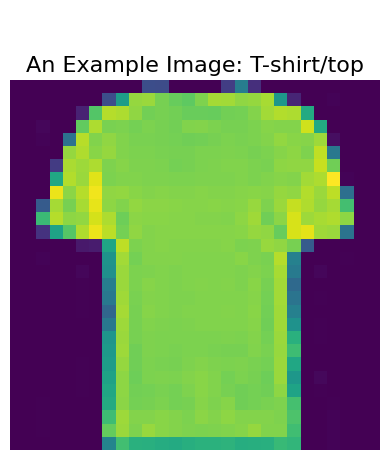

In [14]:
def show(idx, title):
  plt.figure()
  plt.imshow(test_images[idx].reshape(28,28))
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

import random
rando = random.randint(0,len(test_images)-1)
show(rando, 'An Example Image: {}'.format(class_names[test_labels[rando]]))

Ok, that looks interesting.  How hard is that for you to recognize? Now let's create the JSON object for a batch of  three inference requests, and see how well our model recognizes things:

In [15]:
import json
data = json.dumps({"signature_name": "serving_default", "instances": test_images[0:3].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ...  [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]]}


### Make REST requests

#### Newest version of the servable

We'll send a predict request as a POST to our server's REST endpoint, and pass it three examples.  We'll ask our server to give us the latest version of our servable by not specifying a particular version.

In [ ]:
# docs_infra: no_execute
!pip install -q requests

import requests
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/fashion_model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

show(0, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
  class_names[np.argmax(predictions[0])], np.argmax(predictions[0]), class_names[test_labels[0]], test_labels[0]))

#### A particular version of the servable

Now let's specify a particular version of our servable.  Since we only have one, let's select version 1.  We'll also look at all three results.

In [ ]:
# docs_infra: no_execute
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/fashion_model/versions/1:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

for i in range(0,3):
  show(i, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
    class_names[np.argmax(predictions[i])], np.argmax(predictions[i]), class_names[test_labels[i]], test_labels[i]))